In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import torch
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import torch
import faiss
from prettytable import PrettyTable
import matplotlib.pyplot as plt

import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from dataloader.anaxnet import CustomDataset
from model.anaxnet_attn_multilayer import CustomModel
from common_metrics import compute_metrics

In [3]:
nine_class_labels = [
    'lung opacity', 
    'pleural effusion', 
    'atelectasis', 
    'enlarged cardiac silhouette',
    'pulmonary edema/hazy opacity', 
    'pneumothorax', 
    'consolidation', 
    'fluid overload/heart failure', 
    'pneumonia']

anatomy_names = [
    'right lung',
    'right apical zone',
    'right upper lung zone',
    'right mid lung zone',
    'right lower lung zone',
    'right hilar structures',
    'right costophrenic angle',
    'left lung',
    'left apical zone',
    'left upper lung zone',
    'left mid lung zone',
    'left lower lung zone',
    'left hilar structures',
    'left costophrenic angle',
    'mediastinum',
    'upper mediastinum',
    'cardiac silhouette',
    'trachea']

config = {
    'num_classes': 9,
    'batch_size': 16,
    'lr': 0.0001,
    'num_layers': 6,
    'dropout': 0.0,
    'graph_importance': 0.2,
    'is_global_feat': True,
    'contrastive': False,
    'matryoshka': False,
    'task': 'graph_transformer',
    'run': 'gt_fc_2_layer_no_global_feat_image_only_classification',
    'num_workers': 32
    }

In [17]:
df_dump = pd.read_pickle('/scratch/arihanth.srikar/dump_data/gt_fc_2_layer_no_global_feat_image_only_classification_dump.pickle')

In [18]:
df_dump

,occluded_anatomy,disease,AP,HR,RR,retrieved_match,retrieved_similarity
0,original,lung opacity,0.841226,1,1.0,"[True, False, True, True, True, True, True, Tr...","[0.9811016321182251, 0.9803826808929443, 0.980..."
1,original,lung opacity,1.000000,1,1.0,"[True, True, True, True, True, True, True, Tru...","[0.9768165349960327, 0.975784182548523, 0.9755..."
2,original,lung opacity,0.666156,1,1.0,"[True, False, False, True, True, False, True, ...","[0.9748682975769043, 0.973706841468811, 0.9736..."
3,original,lung opacity,0.841226,1,1.0,"[True, False, True, True, True, True, True, Tr...","[0.977052628993988, 0.9769504070281982, 0.9735..."
4,original,lung opacity,1.000000,1,1.0,"[True, True, True, True, True, True, True, Tru...","[0.9711141586303711, 0.9703130722045898, 0.968..."
...,...,...,...,...,...,...,...
638,trachea,pneumonia,0.200000,1,0.2,"[False, False, False, False, True, False, Fals...","[0.9443334341049194, 0.9429253935813904, 0.940..."
639,trachea,pneumonia,0.000000,0,0.0,"[False, False, False, False, False, False, Fal...","[0.9480199813842773, 0.9447712898254395, 0.942..."
640,trachea,pneumonia,0.634921,1,1.0,"[True, False, True, False, False, False, True,...","[0.9709908962249756, 0.9674741625785828, 0.966..."
641,trachea,pneumonia,0.611111,1,1.0,"[True, False, False, True, False, False, False...","[0.9533147215843201, 0.9501998424530029, 0.950..."


In [19]:
df_dump[df_dump['disease'] == 'pneumonia']

,occluded_anatomy,disease,AP,HR,RR,retrieved_match,retrieved_similarity
0,original,pneumonia,0.825397,1,1.000000,"[True, True, True, False, False, False, True, ...","[0.9789566993713379, 0.9744337797164917, 0.974..."
1,original,pneumonia,0.236111,1,0.250000,"[False, False, False, True, False, False, Fals...","[0.9735650420188904, 0.9719899892807007, 0.971..."
2,original,pneumonia,0.350000,1,0.500000,"[False, True, False, False, False, False, Fals...","[0.9864425659179688, 0.9859921932220459, 0.985..."
3,original,pneumonia,0.196429,1,0.142857,"[False, False, False, False, False, False, Tru...","[0.9777171611785889, 0.9754145741462708, 0.974..."
4,original,pneumonia,0.857143,1,1.000000,"[True, True, True, False, True, True, False, F...","[0.9798076748847961, 0.9792556762695312, 0.977..."
...,...,...,...,...,...,...,...
638,trachea,pneumonia,0.200000,1,0.200000,"[False, False, False, False, True, False, Fals...","[0.9443334341049194, 0.9429253935813904, 0.940..."
639,trachea,pneumonia,0.000000,0,0.000000,"[False, False, False, False, False, False, Fal...","[0.9480199813842773, 0.9447712898254395, 0.942..."
640,trachea,pneumonia,0.634921,1,1.000000,"[True, False, True, False, False, False, True,...","[0.9709908962249756, 0.9674741625785828, 0.966..."
641,trachea,pneumonia,0.611111,1,1.000000,"[True, False, False, True, False, False, False...","[0.9533147215843201, 0.9501998424530029, 0.950..."


In [20]:
dfs = {k: df_dump[df_dump['occluded_anatomy'] == k].copy() for k in df_dump['occluded_anatomy'].unique()}

In [21]:
# print color coded table
t = PrettyTable(['Disease', 'Occluded Anatomy', 'Original mAP', 'Occluded mAP', 'Original mHR', 'Occluded mHR', 'Original mRR', 'Occluded mRR'])
t_color = PrettyTable(['Disease', 'Occluded Anatomy', 'Original mAP', 'Occluded mAP', 'Original mHR', 'Occluded mHR', 'Original mRR', 'Occluded mRR'])
for pick_disease in nine_class_labels:
    for pick_anatomy in dfs.keys():
        orig = dfs['original'][dfs['original']['disease'] == pick_disease]
        orig_mAP = orig['AP'].sum() / orig['HR'].sum() if orig['HR'].sum() != 0 else 0.0
        orig_mHR = orig['HR'].sum() / orig['HR'].count()
        orig_mRR = orig['RR'].sum() / orig['HR'].sum() if orig['HR'].sum() != 0 else 0.0
        occluded = dfs[pick_anatomy][dfs[pick_anatomy]['disease'] == pick_disease]
        occluded_mAP = occluded['AP'].sum() / occluded['HR'].sum() if occluded['HR'].sum() != 0 else 0.0
        occluded_mHR = occluded['HR'].sum() / occluded['HR'].count()
        occluded_mRR = occluded['RR'].sum() / occluded['HR'].sum() if occluded['HR'].sum() != 0 else 0.0

        t.add_row([pick_disease, pick_anatomy, round(orig_mAP, 2), round(occluded_mAP, 2), round(orig_mHR, 2), round(occluded_mHR, 2), round(orig_mRR, 2), round(occluded_mRR, 2)])

        # color code each metric: mAP, mHR, mRR
        if orig_mAP <= occluded_mAP:
            occluded_mAP = '\033[92m' + str(round(occluded_mAP, 2)) + '\033[0m'
        else:
            occluded_mAP = '\033[91m' + str(round(occluded_mAP, 2)) + '\033[0m'

        if orig_mHR <= occluded_mHR:
            occluded_mHR = '\033[92m' + str(round(occluded_mHR, 2)) + '\033[0m'
        else:
            occluded_mHR = '\033[91m' + str(round(occluded_mHR, 2)) + '\033[0m'

        if orig_mRR <= occluded_mRR:
            occluded_mRR = '\033[92m' + str(round(occluded_mRR, 2)) + '\033[0m'
        else:
            occluded_mRR = '\033[91m' + str(round(occluded_mRR, 2)) + '\033[0m'

        orig_mAP = str(round(orig_mAP, 2))
        orig_mHR = str(round(orig_mHR, 2))
        orig_mRR = str(round(orig_mRR, 2))

        t_color.add_row([pick_disease, pick_anatomy, orig_mAP, occluded_mAP, orig_mHR, occluded_mHR, orig_mRR, occluded_mRR])

    # add empty row
    t.add_row(['', '', '', '', '', '', '', ''])
    t_color.add_row(['', '', '', '', '', '', '', ''])

print(t_color)

+------------------------------+--------------------------------------------------+--------------+--------------+--------------+--------------+--------------+--------------+
|           Disease            |                 Occluded Anatomy                 | Original mAP | Occluded mAP | Original mHR | Occluded mHR | Original mRR | Occluded mRR |
+------------------------------+--------------------------------------------------+--------------+--------------+--------------+--------------+--------------+--------------+
|         lung opacity         |                     original                     |     0.91     |     0.91     |     1.0      |     1.0      |     0.94     |     0.94     |
|         lung opacity         |               right_lung-left_lung               |     0.91     |     0.78     |     1.0      |     1.0      |     0.94     |     0.54     |
|         lung opacity         |        right_apical_zone-left_apical_zone        |     0.91     |     0.89     |     1.0      |  

In [22]:
df_disease_dump = pd.read_pickle('/scratch/arihanth.srikar/dump_disease_data/gt_fc_2_layer_no_global_feat_image_only_classification_dump.pickle')

In [23]:
df_disease_dump

,consider_disease,disease,AP,HR,RR,retrieved_match,retrieved_similarity
0,lung opacity,lung opacity,0.000000,0,0.000000,"[False, False, False, False, False, False, Fal...","[0.9743533134460449, 0.9734647274017334, 0.972..."
1,lung opacity,lung opacity,0.000000,0,0.000000,"[False, False, False, False, False, False, Fal...","[0.9677982330322266, 0.9661726951599121, 0.965..."
2,lung opacity,lung opacity,0.000000,0,0.000000,"[False, False, False, False, False, False, Fal...","[0.973651111125946, 0.9729244112968445, 0.9709..."
3,lung opacity,lung opacity,0.000000,0,0.000000,"[False, False, False, False, False, False, Fal...","[0.965609073638916, 0.9655654430389404, 0.9653..."
4,lung opacity,lung opacity,0.000000,0,0.000000,"[False, False, False, False, False, False, Fal...","[0.9635603427886963, 0.9616623520851135, 0.961..."
...,...,...,...,...,...,...,...
638,original,pneumonia,0.361111,1,0.500000,"[False, True, False, False, False, False, Fals...","[0.9736254811286926, 0.9689266085624695, 0.968..."
639,original,pneumonia,0.111111,1,0.111111,"[False, False, False, False, False, False, Fal...","[0.9759107828140259, 0.9732922315597534, 0.972..."
640,original,pneumonia,0.320635,1,0.200000,"[False, False, False, False, True, True, True,...","[0.983218789100647, 0.9828979969024658, 0.9826..."
641,original,pneumonia,0.696825,1,0.500000,"[False, True, True, True, True, False, True, T...","[0.9794505834579468, 0.9780653715133667, 0.976..."


In [24]:
dfs_disease = {k: df_disease_dump[df_disease_dump['consider_disease'] == k].copy() for k in df_disease_dump['consider_disease'].unique()}

In [25]:
# print color coded table
t = PrettyTable(['Disease', 'Occluded for Disease', 'Original mAP', 'Occluded mAP', 'Original mHR', 'Occluded mHR', 'Original mRR', 'Occluded mRR'])
t_color = PrettyTable(['Disease', 'Occluded for Disease', 'Original mAP', 'Occluded mAP', 'Original mHR', 'Occluded mHR', 'Original mRR', 'Occluded mRR'])
for pick_anatomy in dfs_disease.keys():
    for pick_disease in nine_class_labels:
        orig = dfs_disease['original'][dfs_disease['original']['disease'] == pick_disease]
        orig_mAP = orig['AP'].sum() / orig['HR'].sum() if orig['HR'].sum() != 0 else 0.0
        orig_mHR = orig['HR'].sum() / orig['HR'].count()
        orig_mRR = orig['RR'].sum() / orig['HR'].sum() if orig['HR'].sum() != 0 else 0.0
        occluded = dfs_disease[pick_anatomy][dfs_disease[pick_anatomy]['disease'] == pick_disease]
        occluded_mAP = occluded['AP'].sum() / occluded['HR'].sum() if occluded['HR'].sum() != 0 else 0.0
        occluded_mHR = occluded['HR'].sum() / occluded['HR'].count()
        occluded_mRR = occluded['RR'].sum() / occluded['HR'].sum() if occluded['HR'].sum() != 0 else 0.0

        t.add_row([pick_disease, pick_anatomy, round(orig_mAP, 2), round(occluded_mAP, 2), round(orig_mHR, 2), round(occluded_mHR, 2), round(orig_mRR, 2), round(occluded_mRR, 2)])

        # color code each metric: mAP, mHR, mRR
        if orig_mAP <= occluded_mAP:
            occluded_mAP = '\033[92m' + str(round(occluded_mAP, 2)) + '\033[0m'
        else:
            occluded_mAP = '\033[91m' + str(round(occluded_mAP, 2)) + '\033[0m'

        if orig_mHR <= occluded_mHR:
            occluded_mHR = '\033[92m' + str(round(occluded_mHR, 2)) + '\033[0m'
        else:
            occluded_mHR = '\033[91m' + str(round(occluded_mHR, 2)) + '\033[0m'

        if orig_mRR <= occluded_mRR:
            occluded_mRR = '\033[92m' + str(round(occluded_mRR, 2)) + '\033[0m'
        else:
            occluded_mRR = '\033[91m' + str(round(occluded_mRR, 2)) + '\033[0m'

        orig_mAP = str(round(orig_mAP, 2))
        orig_mHR = str(round(orig_mHR, 2))
        orig_mRR = str(round(orig_mRR, 2))

        t_color.add_row([pick_disease, pick_anatomy, orig_mAP, occluded_mAP, orig_mHR, occluded_mHR, orig_mRR, occluded_mRR])

    # add empty row
    t.add_row(['', '', '', '', '', '', '', ''])
    t_color.add_row(['', '', '', '', '', '', '', ''])

print(t_color)

+------------------------------+------------------------------+--------------+--------------+--------------+--------------+--------------+--------------+
|           Disease            |     Occluded for Disease     | Original mAP | Occluded mAP | Original mHR | Occluded mHR | Original mRR | Occluded mRR |
+------------------------------+------------------------------+--------------+--------------+--------------+--------------+--------------+--------------+
|         lung opacity         |         lung opacity         |     0.91     |     0.55     |     1.0      |     0.03     |     0.94     |     0.6      |
|       pleural effusion       |         lung opacity         |     0.7      |     0.46     |     0.99     |     0.04     |     0.78     |     0.52     |
|         atelectasis          |         lung opacity         |     0.61     |     0.42     |     0.98     |     0.07     |     0.7      |     0.44     |
| enlarged cardiac silhouette  |         lung opacity         |     0.65    

In [8]:
anatomy_inp_name = '/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/anatomy_matrix.csv'
anatomy_inp = pd.read_csv(anatomy_inp_name, sep='\t')
anatomy_inp

,right lung,right apical zone,right upper lung zone,right mid lung zone,right lower lung zone,right hilar structures,right costophrenic angle,left lung,left apical zone,left upper lung zone,left mid lung zone,left lower lung zone,left hilar structures,left costophrenic angle,mediastinum,upper mediastinum,cardiac silhouette,trachea
0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
def print_image(img):
    img -= img.min()
    img /= img.max()
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

In [10]:
print("Loading dataset")
df = pd.read_json('/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/mimic_coco_filtered.json')
temp_df = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-final.csv')
temp_df.rename(columns={'dicom_id': 'image_id'}, inplace=True)
df = df.merge(temp_df, on='image_id', how='left')
print("Dataset loaded")

Loading dataset


Dataset loaded


In [11]:
test_dataset = CustomDataset(df, split='test', return_masked_img=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])

In [12]:
all_labels = []
y_9 = []
all_ids = []

for batch in tqdm(test_loader):
    y = (torch.sum(batch['y'], dim=1) > 0).int()
    ids = batch['idx']
    
    all_labels.append(y)
    all_ids.append(ids)
    y_9.append(batch['y'])

100%|██████████| 200/200 [01:23<00:00,  2.41it/s]


In [13]:
all_ids = torch.cat(all_ids).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()
y_9 = torch.cat(y_9).cpu().numpy()

In [14]:
y_9.shape

(3191, 18, 9)

In [16]:
amaze_matrix = np.zeros((len(anatomy_names), len(nine_class_labels)), dtype=np.int32)
disease_sum = np.zeros((len(nine_class_labels)), dtype=np.int32)
for data_point in tqdm(y_9.astype(np.int32)):
    disease_sum += (np.sum(data_point, axis=0) > 0).astype(np.int32)
    for i, anatomy in enumerate(anatomy_names):
        for j, disease in enumerate(nine_class_labels):
            amaze_matrix[i, j] += data_point[i, j]
np.round(100*amaze_matrix/disease_sum, 1)

t = PrettyTable(['Anatomy'] + nine_class_labels)
t.title = 'Anatomy-Disease Distribution'
for i, anatomy in enumerate(anatomy_names):
    t.add_row([anatomy] + list(np.round(100*amaze_matrix[i]/disease_sum, 1)))
print(t)
with open('data/anatomy_disease_distribution.txt', 'w') as f:
    f.write(str(t))

100%|██████████| 3191/3191 [00:00<00:00, 11112.39it/s]

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                           Anatomy-Disease Distribution                                                                                          |
+--------------------------+--------------+------------------+-------------+-----------------------------+------------------------------+--------------+---------------+------------------------------+-----------+
|         Anatomy          | lung opacity | pleural effusion | atelectasis | enlarged cardiac silhouette | pulmonary edema/hazy opacity | pneumothorax | consolidation | fluid overload/heart failure | pneumonia |
+--------------------------+--------------+------------------+-------------+-----------------------------+------------------------------+--------------+

In [19]:
nine_class_labels

['lung opacity',
 'pleural effusion',
 'atelectasis',
 'enlarged cardiac silhouette',
 'pulmonary edema/hazy opacity',
 'pneumothorax',
 'consolidation',
 'fluid overload/heart failure',
 'pneumonia']

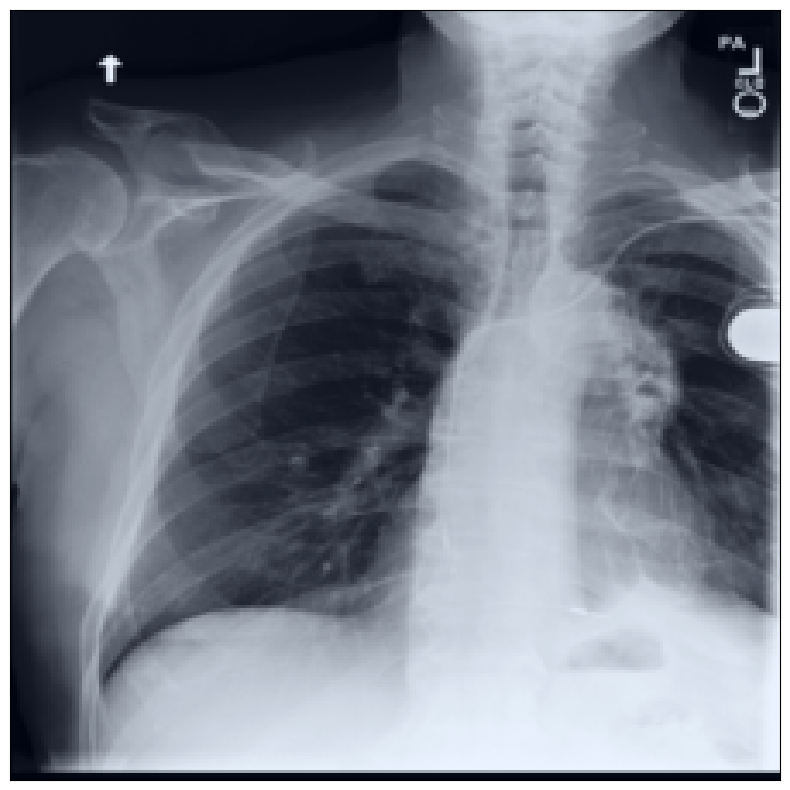

In [51]:
consider_anatomy = 'right lung'
consider_anatomy_id = anatomy_names.index(consider_anatomy)

consider_disease = 'pleural effusion'
consider_disease_id = nine_class_labels.index(consider_disease)
batch = test_dataset.__getitem__(np.random.choice(all_ids[all_labels[:, consider_disease_id] == 1]))

img = batch['global_feat']
img -= img.min()
img /= img.max()
img = img.permute(1, 2, 0).cpu().numpy()
img = (img * 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

In [5]:
# load model from checkpoint
model_paths = sorted(glob(f'/home/ssd_scratch/users/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))
if len(model_paths) == 0: model_paths = sorted(glob(f'/scratch/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))

In [6]:
model_criteria = 'auc'
model_path = [md_name for md_name in model_paths if model_criteria in md_name][-1]
print(f'Loading best model based on {model_criteria}')
model = CustomModel.load_from_checkpoint(model_path, config=config)

Loading best model based on auc


In [14]:
device = 'cuda'
model = model.to(device)
model = model.eval()

In [12]:
all_emb = []
all_labels = []

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        node_feats = batch['node_feat'].to(device)
        global_feat = batch['global_feat'].to(device)
        y = torch.sum(batch['y'], dim=1) > 0
        emb = model.retrieval_pass(node_feats, global_feat)
        all_emb.append(emb.detach().cpu().numpy())
        all_labels.append(y.numpy())

# cache for later use
all_emb = np.concatenate(all_emb)
all_labels = np.concatenate(all_labels)
print(all_emb.shape, all_labels.shape)
np.save(f'/tmp/anaxnet_emb_{model_criteria}.npy', all_emb)
np.save(f'/tmp/anaxnet_labels_{model_criteria}.npy', all_labels)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:31<00:00,  2.18it/s]

(3191, 1024) (3191, 9)


In [13]:
d = all_emb.shape[1]
all_emb = all_emb/np.linalg.norm(all_emb, axis=1, keepdims=True)

faiss_retriever = faiss.IndexFlatIP(d)
faiss_retriever.add(all_emb)
print(f'\nFaiss trained {faiss_retriever.is_trained} on {faiss_retriever.ntotal} vectors of size {faiss_retriever.d}')


Faiss trained True on 3191 vectors of size 1024


In [14]:
good_img_ids = [498, 1159]

In [99]:
rand_id = np.random.randint(0, len(test_dataset))
print(f'Randomly selected image id: {rand_id}')
sample = test_dataset.__getitem__(rand_id)

normal_node_feats = sample['node_feat'].unsqueeze(0).to(device)
normal_global_feat = sample['global_feat'].unsqueeze(0).to(device)
normal_emb = model.retrieval_pass(normal_node_feats, normal_global_feat).detach().cpu().numpy()
normal_emb = normal_emb/np.linalg.norm(normal_emb, axis=1, keepdims=True)
y = list(np.array(nine_class_labels)[(torch.sum(sample['y'], axis=0) > 0)])
ys = {anatomy_names[i]: list(np.array(nine_class_labels)[y]) for i, y in enumerate(sample['y'] > 0) if len(list(np.array(nine_class_labels)[y]))}

D_orig, I_orig = faiss_retriever.search(normal_emb, 10)

node_ids = [i for _ in range(len(anatomy_names))]
occluded_similarities = {a_name: {} for a_name in anatomy_names}
original_similarities = {d: np.dot(normal_emb, all_emb[d].T)[0] for d in I_orig[0]}

for i, a_name in enumerate(anatomy_names):
    occluded_node_feats = sample['node_feat'].unsqueeze(0).to(device)
    occluded_node_feats[:, i] = 0
    occluded_emb = model.retrieval_pass(occluded_node_feats, normal_global_feat).detach().cpu().numpy()
    occluded_emb = occluded_emb/np.linalg.norm(occluded_emb, axis=1, keepdims=True)

    occluded_similarities[a_name] = {d: np.dot(occluded_emb, all_emb[d].T)[0] for d in I_orig[0]}

Randomly selected image id: 1491


Text(0.5, 0.98, 'Anatomical Ablation for image id: 1491\nWith classes: lung opacity\nright lung: lung opacity\nright upper lung zone: lung opacity\nright mid lung zone: lung opacity\nleft lung: lung opacity\nleft upper lung zone: lung opacity\nleft mid lung zone: lung opacity')

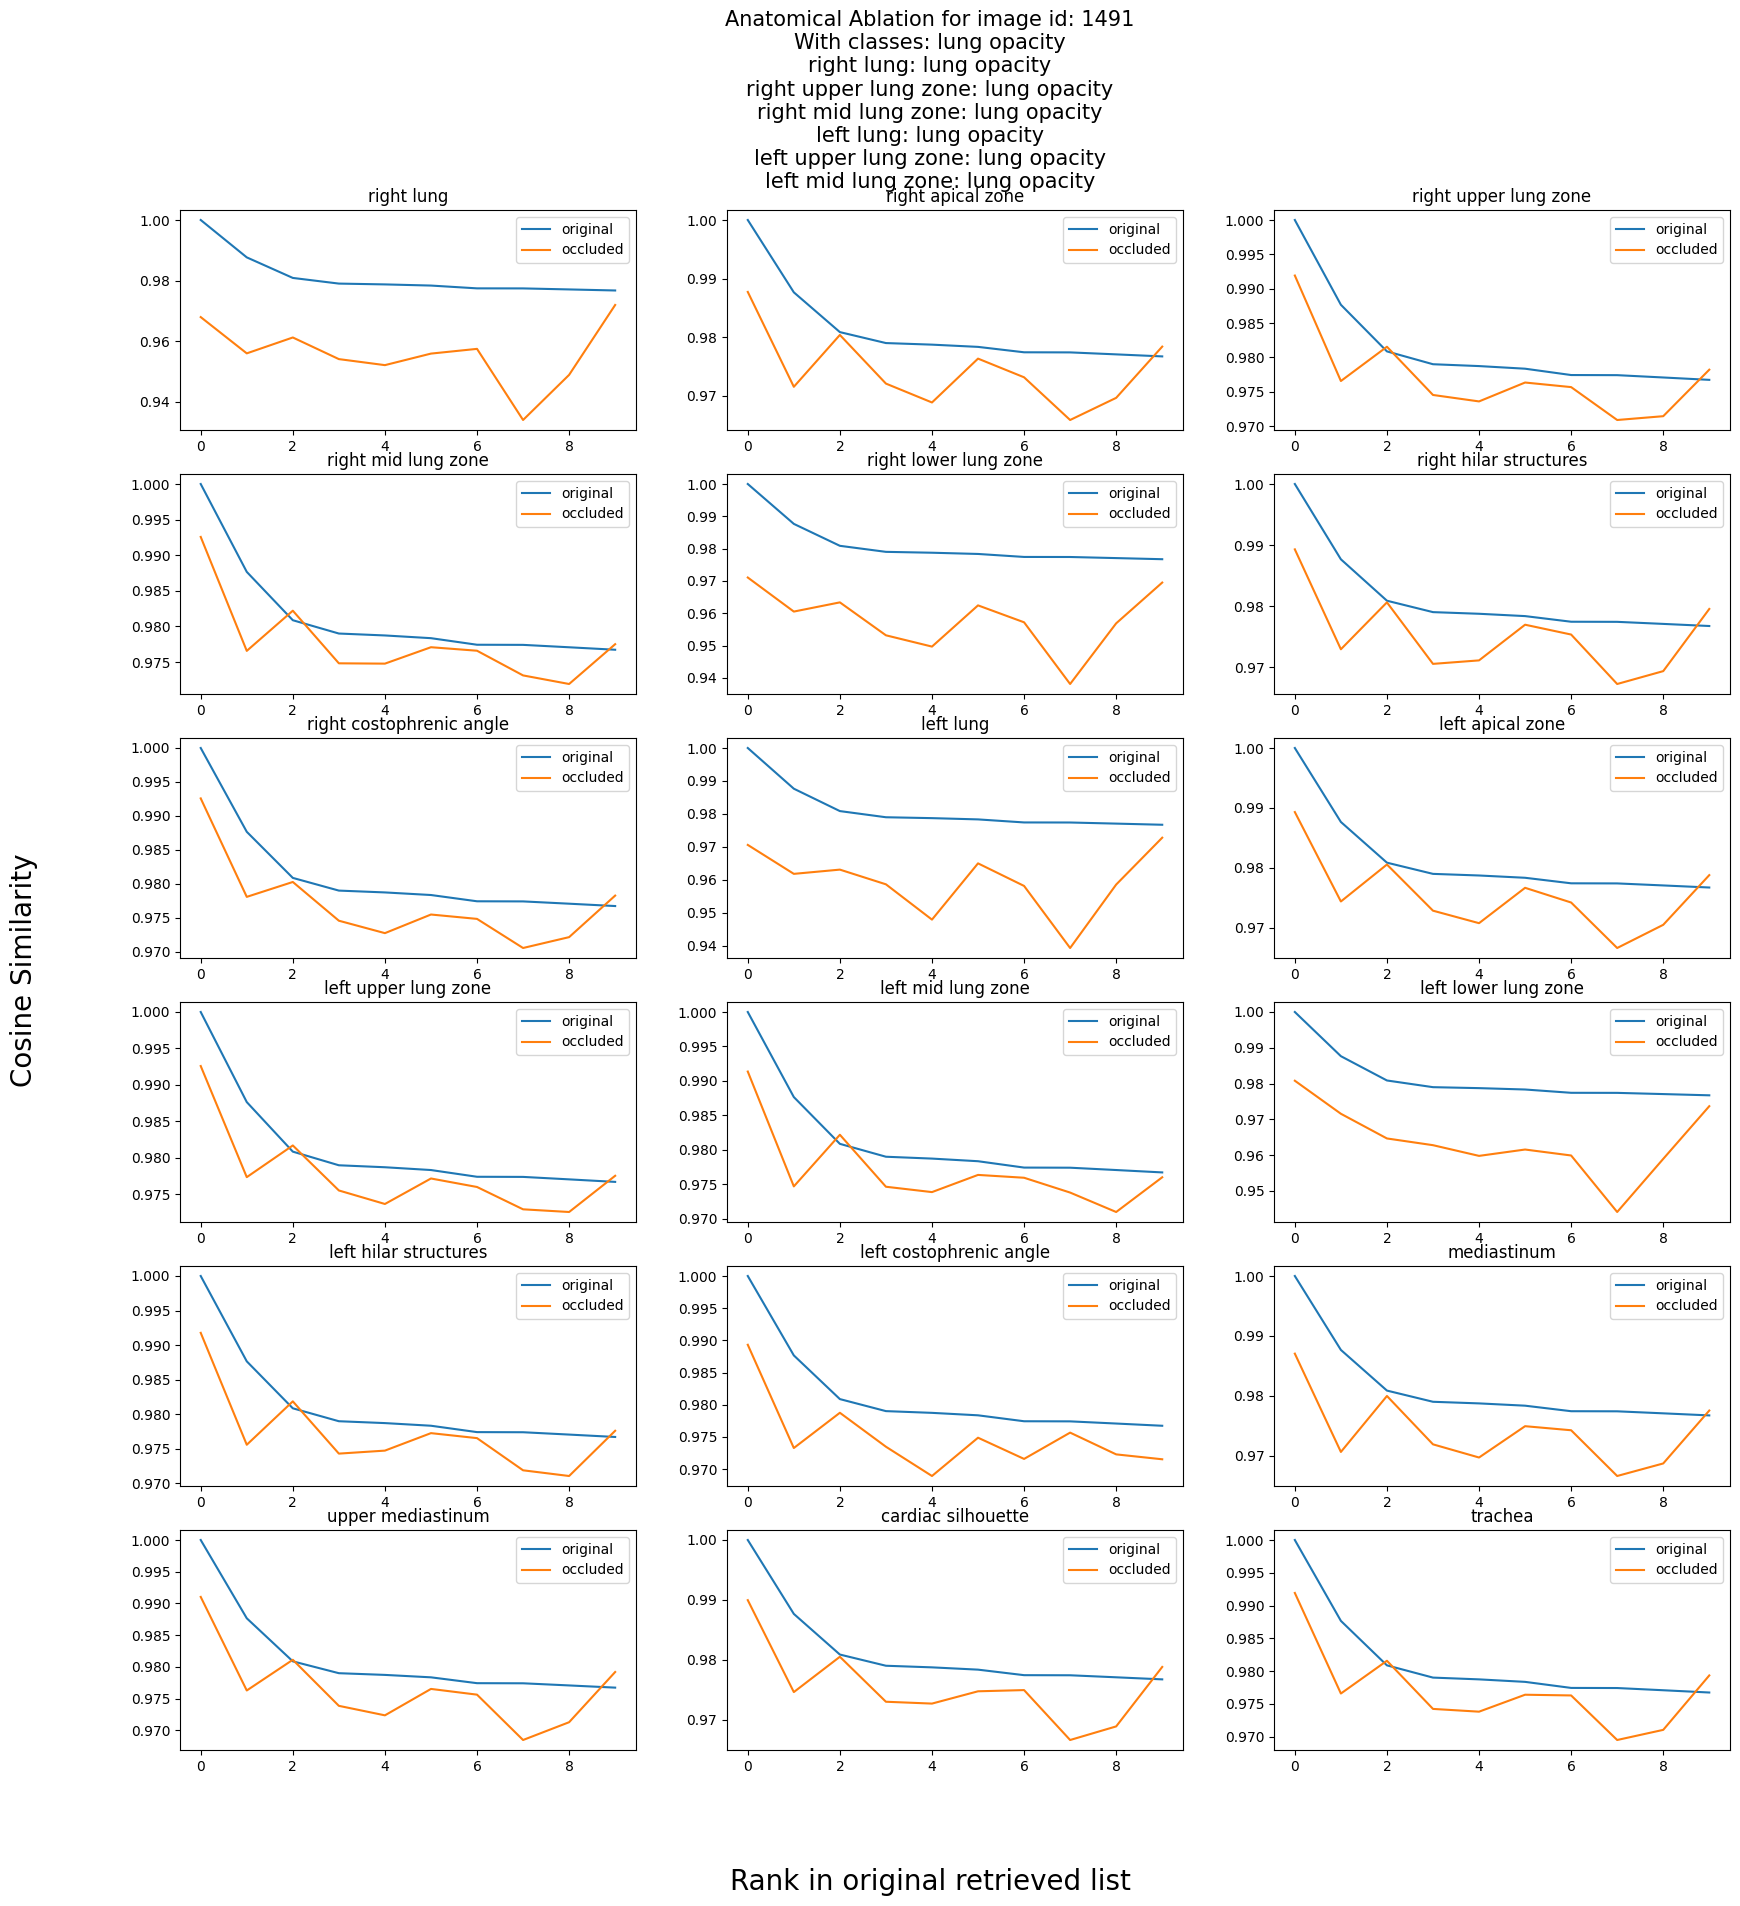

In [100]:
# for each class plot the similarities in a grid
fig, axs = plt.subplots(6, 3, figsize=(20, 20))
axs = axs.ravel()
for i, a_name in enumerate(anatomy_names):
    axs[i].plot(list(original_similarities.values()), label='original')
    axs[i].plot(list(occluded_similarities[a_name].values()), label='occluded')
    axs[i].set_title(a_name)
    axs[i].legend()
fig.text(0.5, 0.04, 'Rank in original retrieved list', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Cosine Similarity', va='center', rotation='vertical', fontsize=20)
class_desc = '\n'.join([f'{k}: {", ".join(v)}' for k, v in ys.items()])
plt.suptitle(f'Anatomical Ablation for image id: {rand_id}\nWith classes: {", ".join(y)}\n{class_desc}', fontsize=15)

In [101]:
node_ids = [i for _ in range(len(anatomy_names))]
occluded_similarities_masked = {a_name: {} for a_name in anatomy_names}
original_similarities_masked = {d: np.dot(normal_emb, all_emb[d].T)[0] for d in I_orig[0]}

for i, a_name in enumerate(anatomy_names):
    occluded_node_feats = sample['node_feat'].unsqueeze(0).to(device)
    occluded_node_feats[:, i] = 0
    mask = sample['masked_img'][i].to(device)
    masked_global_feat = normal_global_feat * mask
    occluded_emb = model.retrieval_pass(occluded_node_feats, masked_global_feat).detach().cpu().numpy()
    occluded_emb = occluded_emb/np.linalg.norm(occluded_emb, axis=1, keepdims=True)

    occluded_similarities_masked[a_name] = {d: np.dot(occluded_emb, all_emb[d].T)[0] for d in I_orig[0]}

Text(0.5, 0.98, 'Anatomical Ablation Masking Global Feature for image id: 1491\nWith classes: lung opacity\nright lung: lung opacity\nright upper lung zone: lung opacity\nright mid lung zone: lung opacity\nleft lung: lung opacity\nleft upper lung zone: lung opacity\nleft mid lung zone: lung opacity')

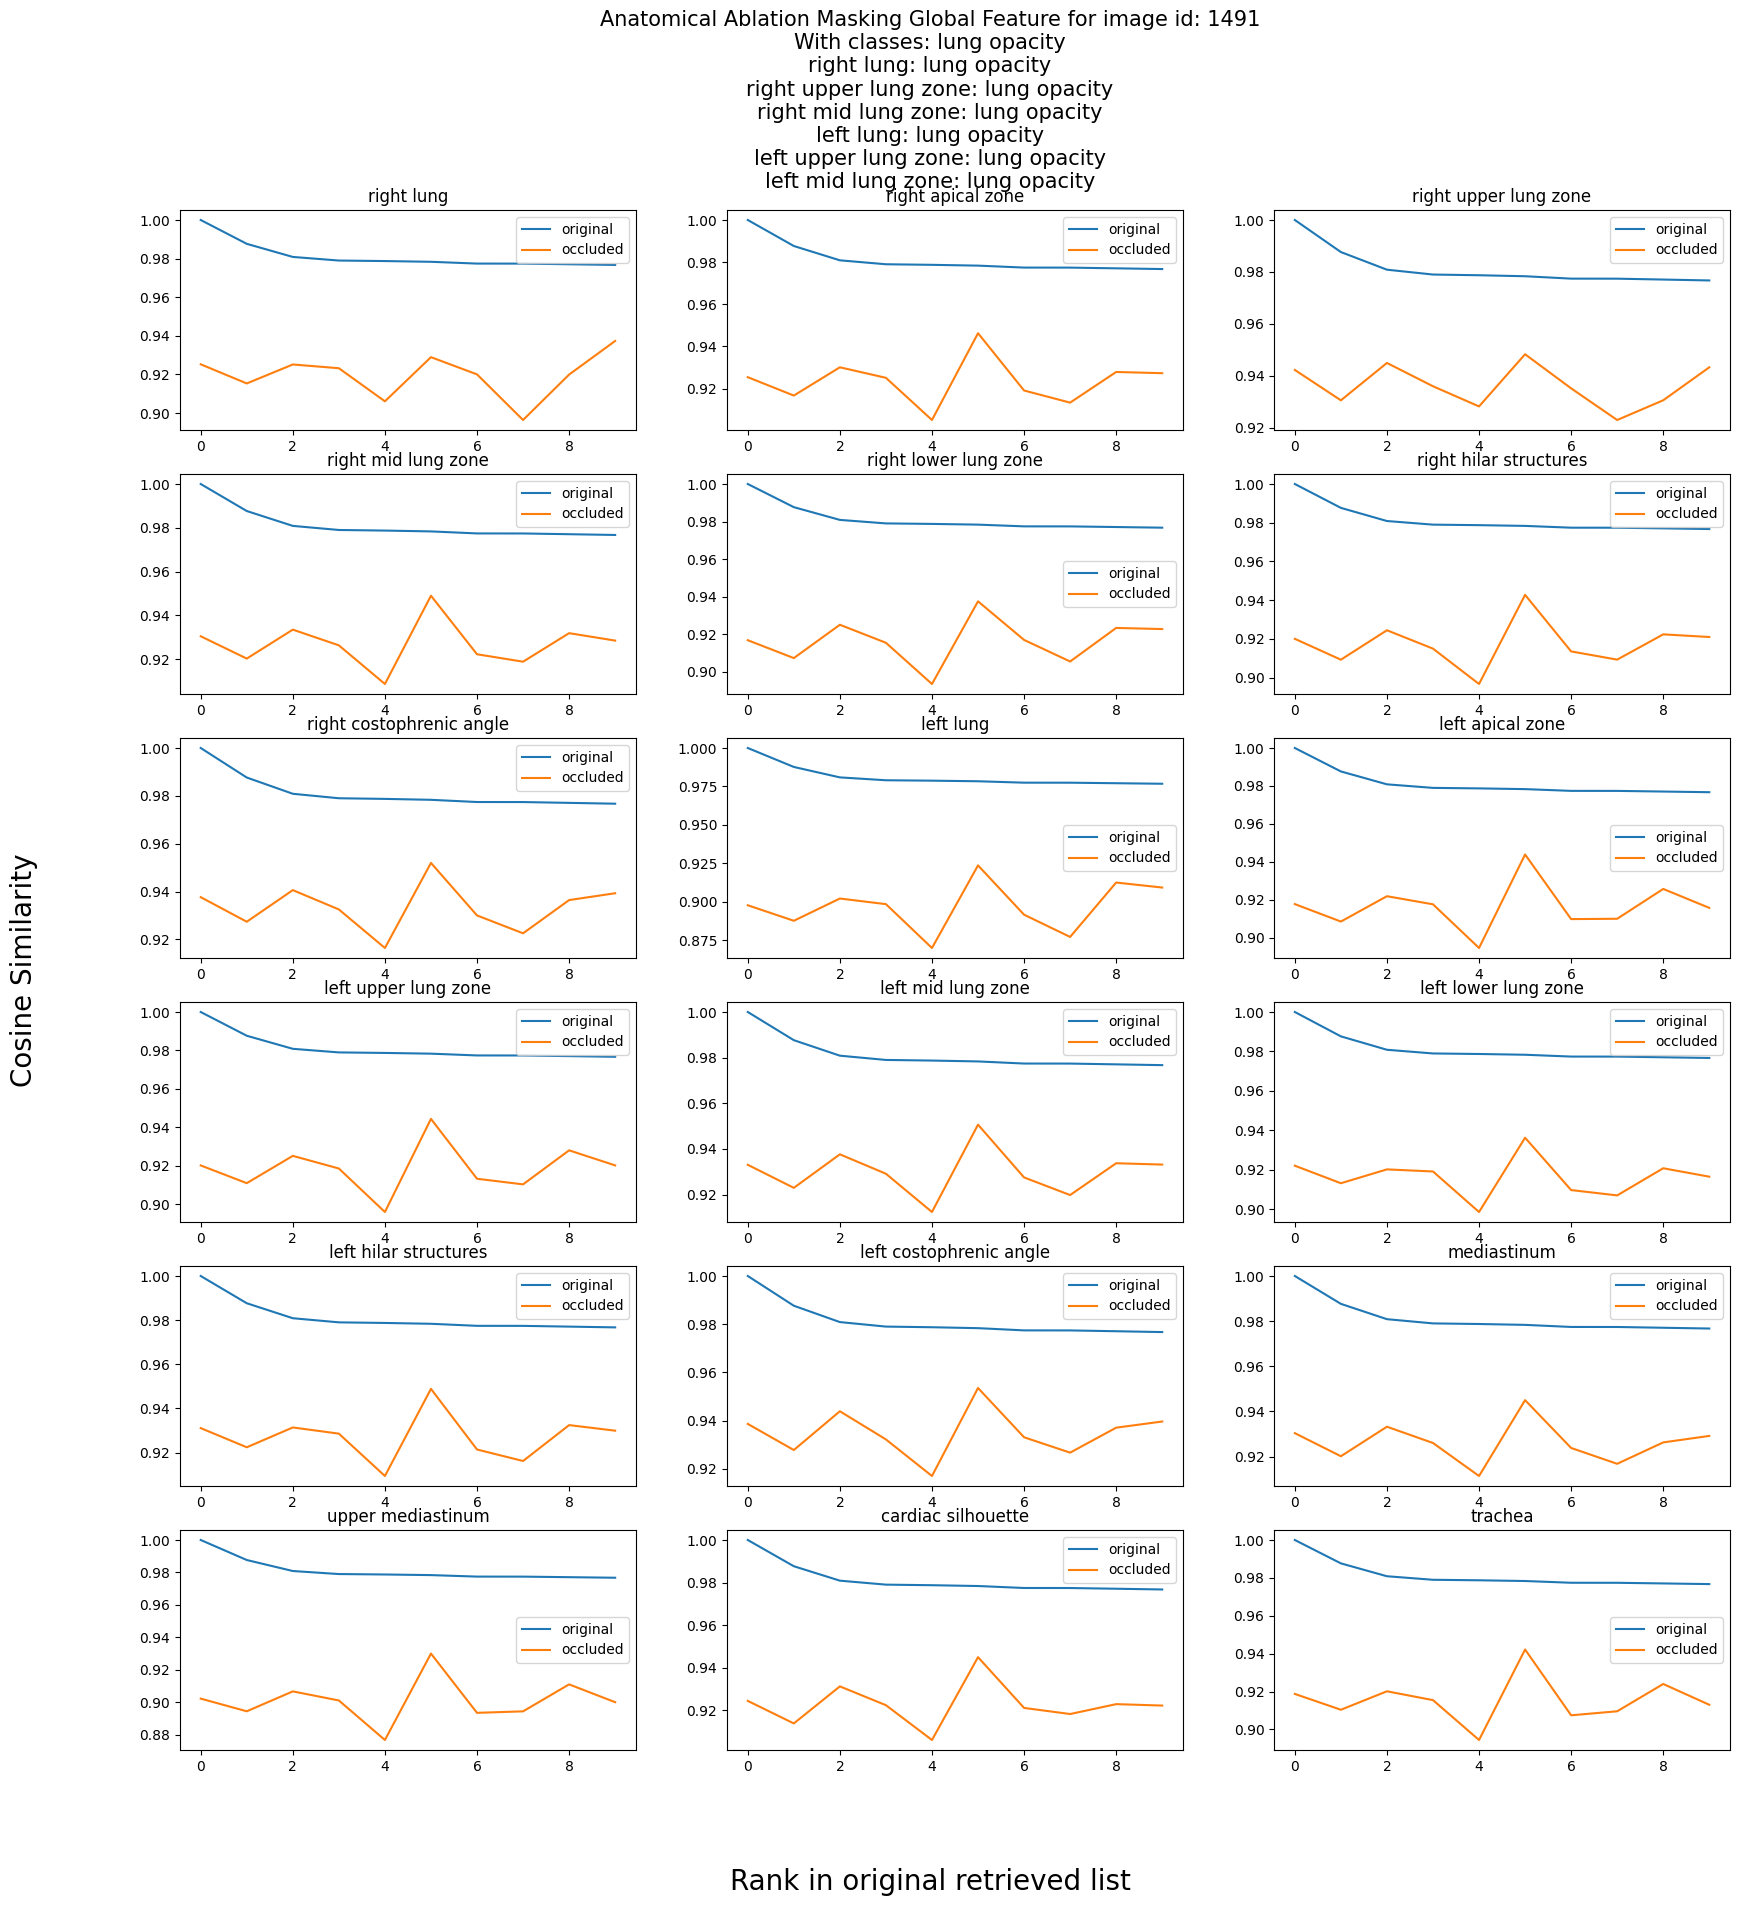

In [102]:
# for each class plot the similarities in a grid
fig, axs = plt.subplots(6, 3, figsize=(20, 20))
axs = axs.ravel()
for i, a_name in enumerate(anatomy_names):
    axs[i].plot(list(original_similarities_masked.values()), label='original')
    axs[i].plot(list(occluded_similarities_masked[a_name].values()), label='occluded')
    axs[i].set_title(a_name)
    axs[i].legend()
fig.text(0.5, 0.04, 'Rank in original retrieved list', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Cosine Similarity', va='center', rotation='vertical', fontsize=20)
class_desc = '\n'.join([f'{k}: {", ".join(v)}' for k, v in ys.items()])
plt.suptitle(f'Anatomical Ablation Masking Global Feature for image id: {rand_id}\nWith classes: {", ".join(y)}\n{class_desc}', fontsize=15)

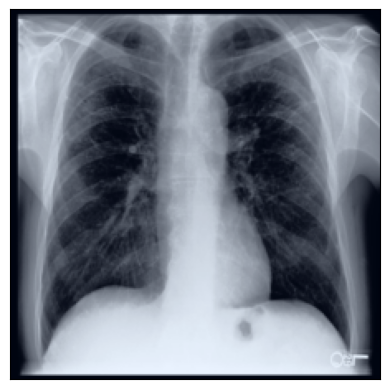

In [103]:
temp_img = sample['global_feat'].permute(1, 2, 0).numpy()
temp_img -= np.min(temp_img)
temp_img /= np.max(temp_img)
temp_img = (temp_img * 255).astype(np.uint8)
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.imshow(temp_img)

In [122]:
all_tables = []

for search_id in list(original_similarities.keys()):
    t = PrettyTable()
    t.field_names = ['Occluded Anatomy', 'Occluded Similarity', 'Occluded Similarity Global Image Masked']
    t.title = f'Anatomical Ablation on query: {rand_id} and retrieved: {search_id} with original similarity: {original_similarities[search_id]:.3f}, Match: {",".join([nine_class_labels[i] for i, m in enumerate(all_labels[search_id] == 1) if m and all_labels[rand_id][i] == 1])}'

    for _, a_name in enumerate(anatomy_names):
        t.add_row([a_name, np.round(occluded_similarities[a_name][search_id], 3), np.round(occluded_similarities_masked[a_name][search_id], 3)])

    all_tables.append(t)

In [123]:
print(all_tables[1])

+-------------------------------------------------------------------------------------------------------------+
| Anatomical Ablation on query: 1491 and retrieved: 2774 with original similarity: 0.988, Match: lung opacity |
+-------------------------------+-------------------------+---------------------------------------------------+
|        Occluded Anatomy       |   Occluded Similarity   |      Occluded Similarity Global Image Masked      |
+-------------------------------+-------------------------+---------------------------------------------------+
|           right lung          |          0.956          |                       0.915                       |
|       right apical zone       |          0.972          |                       0.917                       |
|     right upper lung zone     |          0.977          |                       0.931                       |
|      right mid lung zone      |          0.977          |                        0.92                 

In [124]:
print(all_tables[7])

+-------------------------------------------------------------------------------------------------+
| Anatomical Ablation on query: 1491 and retrieved: 2931 with original similarity: 0.977, Match:  |
+----------------------------+----------------------+---------------------------------------------+
|      Occluded Anatomy      | Occluded Similarity  |   Occluded Similarity Global Image Masked   |
+----------------------------+----------------------+---------------------------------------------+
|         right lung         |        0.934         |                    0.896                    |
|     right apical zone      |        0.966         |                    0.913                    |
|   right upper lung zone    |        0.971         |                    0.923                    |
|    right mid lung zone     |        0.973         |                    0.919                    |
|   right lower lung zone    |        0.938         |                    0.905                    |
